In [1]:
! pip install torch tqdm
#! pip install --upgrade git+https://github.com/rimgro/biocadprotein.git

You should consider upgrading via the 'C:\Users\User\Desktop\biocadprotein\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
torch.manual_seed(12)
np.random.seed(12)

<h3>Подготовка данных</h3>

In [3]:
from fpgen.prop_prediction.dataset import FPbase
from fpgen.prop_prediction.metrics import get_regression_metrics
from torch.utils.data import TensorDataset, DataLoader

In [4]:
dataset = FPbase('data/fpbase.csv')

# one-hot encoding setup
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
vocab = {aa: i for i, aa in enumerate(amino_acids)}

In [5]:
x_train, y_train = dataset.get_train('em_max')
from sklearn.model_selection import train_test_split

# Split training data into train and validation sets (e.g., 80% train, 20% val)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

x_test, y_test = dataset.get_test('em_max')

In [7]:
def encode_sequences(sequences, vocab, max_length=None):
    """
    One-hot encode protein sequences
    
    Args:
        sequences: List of protein sequences (strings)
        vocab: Amino acid vocabulary dictionary (only used for consistency)
        max_length: Maximum sequence length (will pad/truncate)
    
    Returns:
        One-hot encoded sequences as torch tensor of shape (num_sequences, max_length, 20)
    """
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)
    
    # Standard 20 amino acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
    
    encoded = []
    for seq in sequences:
        # Initialize one-hot matrix for this sequence
        seq_onehot = torch.zeros(max_length, 20)
        
        # Convert to uppercase and encode each amino acid
        seq_upper = seq.upper()
        for i, aa in enumerate(seq_upper):
            if i >= max_length:
                break
            if aa in aa_to_idx:
                seq_onehot[i, aa_to_idx[aa]] = 1.0
            # If amino acid is not in standard 20, leave as zeros (unknown)
        
        encoded.append(seq_onehot)
    
    return torch.stack(encoded)

<h3>Преобразование в one-hot encoding</h3>

In [8]:
x_train_encoded = encode_sequences(x_train, vocab, max_length=200)
x_val_encoded = encode_sequences(x_val, vocab, max_length=200)
x_test_encoded = encode_sequences(x_test, vocab, max_length=200)
x_train_encoded.shape

torch.Size([514, 200, 20])

In [9]:
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [10]:
dataset_train = TensorDataset(x_train_encoded, y_train_tensor)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
    
dataset_val = TensorDataset(x_val_encoded, y_val_tensor)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
    
dataset_test = TensorDataset(x_test_encoded, y_test_tensor)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# Доготовка данных для работы с embeddings ESM C

In [11]:
import pickle

with open('sequence.pickle', 'rb') as file:
    seq = pickle.load(file)

In [ ]:
seq[x_train.iloc[0]].shape

torch.Size([1, 236, 960])

In [12]:
def preprocessing_x(x_tr, x_t, x_v, seq, pad_value=0.0, max_length=None):
    """
    Improved preprocessing function for LSTM training with ESM embeddings
    
    Args:
        x_tr, x_t, x_v: Index arrays for train, test, val
        seq: Dictionary/list containing the embeddings
        pad_value: Value to use for padding (default: 0.0)
        max_length: Maximum sequence length (if None, computed from data)
    """
    
    def get_cleaned_tensors(indexes):
        cleaned = []
        for i in range(len(indexes)):
            tensor = seq[indexes.iloc[i]]  # shape: [1, L, D]
            
            # Handle different input shapes
            if tensor.dim() == 3 and tensor.shape[0] == 1:
                tensor = tensor.squeeze(0)  # Now shape: [L, D]
            elif tensor.dim() == 2:
                pass  # Already correct shape
            else:
                raise ValueError(f"Unexpected tensor shape: {tensor.shape}")
            
            # Ensure tensor is float and on CPU for consistent processing
            tensor = tensor.float()
            
            # Basic validation
            if tensor.shape[0] == 0:
                raise ValueError("Found empty sequence")
            if torch.isnan(tensor).any() or torch.isinf(tensor).any():
                print(f"Warning: Found NaN/Inf values in tensor, replacing with zeros")
                tensor = torch.nan_to_num(tensor, nan=0.0, posinf=1.0, neginf=-1.0)
            
            cleaned.append(tensor)
        return cleaned

    # Extract cleaned tensors
    matrix_tr = get_cleaned_tensors(x_tr)
    matrix_t = get_cleaned_tensors(x_t)
    matrix_v = get_cleaned_tensors(x_v)

    # Find dimensions
    all_tensors = matrix_tr + matrix_t + matrix_v
    
    # Check embedding dimension consistency
    emb_dims = [t.shape[1] for t in all_tensors]
    emb_dim = emb_dims[0]
    if not all(d == emb_dim for d in emb_dims):
        raise ValueError(f"Inconsistent embedding dimensions: {set(emb_dims)}")
    
    # Find max length
    if max_length is None:
        max_len = max(t.shape[0] for t in all_tensors)
    else:
        max_len = max_length
    
    print(f"Max sequence length: {max_len}")
    print(f"Embedding dimension: {emb_dim}")
    print(f"Padding value: {pad_value}")

    def pad_tensor_list(tensor_list, split_name):
        padded = []
        original_lengths = []
        
        for i, t in enumerate(tensor_list):
            seq_len = t.shape[0]
            original_lengths.append(seq_len)
            
            if seq_len > max_len:
                # Truncate if longer than max_len
                t = t[:max_len]
                seq_len = max_len
            
            # Pad sequence length dimension only (embedding dim should be consistent)
            if seq_len < max_len:
                padding = (0, 0, 0, max_len - seq_len)  # (left, right, top, bottom)
                padded_tensor = F.pad(t, padding, mode='constant', value=pad_value)
            else:
                padded_tensor = t
            
            padded.append(padded_tensor)
        
        # Stack into batch
        result = torch.stack(padded)
        
        # Validation
        expected_shape = (len(tensor_list), max_len, emb_dim)
        if result.shape != expected_shape:
            raise ValueError(f"Unexpected output shape for {split_name}: {result.shape}, expected: {expected_shape}")
        
        print(f"{split_name} - Shape: {result.shape}, Lengths: min={min(original_lengths)}, max={max(original_lengths)}, mean={np.mean(original_lengths):.1f}")
        
        return result, original_lengths

    # Process all splits
    train, train_lengths = pad_tensor_list(matrix_tr, "Train")
    test, test_lengths = pad_tensor_list(matrix_t, "Test")
    val, val_lengths = pad_tensor_list(matrix_v, "Val")
    
    # Additional validation
    def validate_output(tensor, name):
        if torch.isnan(tensor).any():
            raise ValueError(f"NaN values found in {name}")
        if torch.isinf(tensor).any():
            raise ValueError(f"Inf values found in {name}")
        
        # Check if too many zeros (might indicate padding issues)
        zero_ratio = (tensor == pad_value).float().mean()
        if zero_ratio > 0.8:
            print(f"Warning: {name} has {zero_ratio:.2%} zero values (heavy padding)")
    
    validate_output(train, "train")
    validate_output(test, "test")
    validate_output(val, "val")
    
    return train, test, val

In [13]:
def pad_with_last_token(tensor, target_length):
    """Pad by repeating the last token instead of zeros"""
    seq_len = tensor.shape[0]
    if seq_len >= target_length:
        return tensor[:target_length]
    
    last_token = tensor[-1:].repeat(target_length - seq_len, 1)
    return torch.cat([tensor, last_token], dim=0)

In [14]:
from torch.nn.utils.rnn import pad_sequence

x_train_p, x_val_p, x_test_p = preprocessing_x(x_train, x_val, x_test, seq)

x_train_p.shape
x_val_p.shape
x_test_p.shape

Max sequence length: 739
Embedding dimension: 960
Padding value: 0.0
Train - Shape: torch.Size([514, 739, 960]), Lengths: min=32, max=739, mean=241.0
Test - Shape: torch.Size([129, 739, 960]), Lengths: min=108, max=488, mean=238.6
Val - Shape: torch.Size([167, 739, 960]), Lengths: min=108, max=487, mean=240.8


torch.Size([167, 739, 960])

In [15]:
y_train_p = torch.tensor(y_train, dtype=torch.float32)  # [643, 1]
y_test_p = torch.tensor(y_test, dtype=torch.float32)
y_val_p = torch.tensor(y_val, dtype=torch.float32)

In [16]:
dataset_train = TensorDataset(x_train_p, y_train_p)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = TensorDataset(x_val_p, y_val_p)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)

dataset_test = TensorDataset(x_test_p, y_test_p)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [17]:
x_train_p

tensor([[[ 5.7537e-03, -2.2964e-03,  2.6722e-03,  ...,  5.8003e-03,
          -6.2449e-03, -1.0297e-02],
         [-3.5950e-04, -5.5967e-03,  3.3674e-02,  ...,  3.1661e-02,
           1.4899e-02,  1.7556e-02],
         [-3.5892e-02, -2.5552e-02,  4.4119e-03,  ...,  5.5391e-02,
           2.1439e-03,  2.2918e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 1.2868e-02, -1.8333e-03,  3.3210e-03,  ...,  5.2421e-03,
          -4.7548e-03, -9.2520e-03],
         [ 2.5347e-03,  2.2133e-03,  1.4290e-03,  ...,  2.6560e-02,
           1.4438e-03, -1.3619e-02],
         [-5.9670e-02, -1.0463e-02,  2.0267e-02,  ...,  4.7756e-02,
          -2.7080e-02,  3.9952e-02],
         ...,
         [ 0.0000e+00,  0

# Классы с моделями

In [10]:
class EmbeddingLSTM(nn.Module):
    """LSTM-based neural network for protein sequence analysis with embedding layers."""
    
    def __init__(self, vocab_size=21, embed_dim=960, hidden_size=256, num_layers=3, dropout_rate=0.5):
        """
        Initialize the LSTM architecture with embedding.
        
        Args:
            vocab_size: Size of vocabulary (21 for 20 amino acids + padding token)
            embed_dim: Dimension of embedding vectors
            hidden_size: Number of hidden units in LSTM layers
            num_layers: Number of LSTM layers
            dropout_rate: Dropout probability for regularization
        """
        super(EmbeddingLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        
        # Input projection layer
        self.input_projection = nn.Linear(embed_dim, hidden_size // 2)
        
        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=hidden_size // 2,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Output layers
        self.fc1 = nn.Linear(hidden_size * 2, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 1)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape [batch_size, sequence_length] with amino acid indices
            
        Returns:
            predictions: Tensor of shape [batch_size, 1] with predicted values
        """
        batch_size, seq_length, esmc_dim = x.size()
        
        # Create mask for padding tokens
        mask = (x != 0).float()  # 1 for real tokens, 0 for padding
        mask = mask[:, :, 0].unsqueeze(-1)
        # Apply mask to embeddings
        x = x * mask
        
        # Project input to hidden dimension
        x = F.relu(self.input_projection(x))
        
        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Apply mask to LSTM output
        lstm_out = lstm_out * mask
        
        # Apply layer normalization
        lstm_out = self.layer_norm(lstm_out)
        
        # Output layers
        x = F.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)

        x = torch.mean(x, dim=1)
        
        return x.squeeze(-1)

In [31]:
class ProteinLSTM(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=256, num_layers=2, 
                 output_dim=1, dropout=0.3, bidirectional=True):
        """
        ProteinLSTM for fluorescent protein sequence analysis using one-hot encoding
        
        Args:
            input_dim: Input dimension (20 for amino acids)
            hidden_dim: Hidden dimension of LSTM layers
            num_layers: Number of LSTM layers
            output_dim: Output dimension (1 for regression, num_classes for classification)
            dropout: Dropout rate
            bidirectional: Whether to use bidirectional LSTM
        """
        super(ProteinLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.input_projection = nn.Linear(input_dim, hidden_dim // 2)
        
        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=hidden_dim // 2,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        
        # Output layers
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        # self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(128, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape [batch_size, sequence_length] with amino acid indices
            
        Returns:
            predictions: Tensor of shape [batch_size, 1] with predicted values
        """

        # print(x)
        # print(x.shape)

        # mask = (x != 0).float()  # 1 for real tokens, 0 for padding
        # mask = mask[:, :, 0]

        # mask = torch.all(x, dim=-1).float().unsqueeze(-1)
        # print(mask)
        # print(mask.shape)
        # Apply mask to embeddings
        # x = x * mask

        
        # Project input to hidden dimension
        x = F.relu(self.input_projection(x))
        
        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(x)

        # lstm_out = lstm_out * mask
        
        # Apply layer normalization
        lstm_out = self.layer_norm(lstm_out[:,-1,:])
        
        # Output layers
        x = F.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        
        # x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x

In [29]:
class EmbeddingsCNN(nn.Module):
    def __init__(self, input_channels=960, seq_len=739):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)

        conv_output_len = seq_len // 4 
        self.fc1 = nn.Linear(32 * conv_output_len, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x: [B, L, C] → [B, C, L]
        x = x.permute(0, 2, 1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [43]:
class ProteinCNN(nn.Module):
    def __init__(self, num_amino_acids=20, embedding_dim=64, num_filters=96, dropout_rate=0.4):
        """
        Initialize the intermediate CNN architecture.
        
        Args:
            num_amino_acids: Vocabulary size (e.g., 20).
            embedding_dim: Size of the learned embedding vector.
            num_filters: Number of filters. Increased slightly to 96 to give more capacity.
            dropout_rate: A more moderate dropout rate.
        """
        super(ProteinCNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=num_amino_acids, embedding_dim=embedding_dim)

        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, num_filters, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(embedding_dim, num_filters, kernel_size=7, padding=3)

        self.batch_norm1 = nn.BatchNorm1d(num_filters)
        self.batch_norm2 = nn.BatchNorm1d(num_filters)
        self.batch_norm3 = nn.BatchNorm1d(num_filters)

        self.conv4 = nn.Conv1d(num_filters * 3, num_filters * 2, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm1d(num_filters * 2)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(num_filters * 2, 256) 
        self.fc_out = nn.Linear(256, 1)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_one_hot):
        """
        Forward pass.
        
        Args:
            x_one_hot: Input tensor of one-hot vectors [batch, seq_len, num_amino_acids]
        """
        x_indices = torch.argmax(x_one_hot, dim=2)
        
        x = self.embedding(x_indices)
        x = x.transpose(1, 2)
        
        conv1_out = F.relu(self.batch_norm1(self.conv1(x)))
        conv2_out = F.relu(self.batch_norm2(self.conv2(x)))
        conv3_out = F.relu(self.batch_norm3(self.conv3(x)))
        
        x = torch.cat([conv1_out, conv2_out, conv3_out], dim=1)
        
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.dropout(x) 
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc_out(x)
        
        return x

### Обучение моделей

In [12]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    """Train the LSTM model."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    print(f"Training on {device}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            sequences, targets = data[0], data[1]
            sequences, targets = sequences.to(device), targets.to(device)
            
            optimizer.zero_grad()
            predictions = model(sequences).squeeze()
            loss = criterion(predictions, targets)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for data in val_loader:
                sequences, targets = data[0], data[1]
                sequences, targets = sequences.to(device), targets.to(device)
                predictions = model(sequences).squeeze()
                loss = criterion(predictions, targets)
                val_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            print("-" * 50)
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [14]:
def evaluate_model(model, data_loader, dataset=None, target_property=None):
    model.eval()
    predictions, true_values = [], []

    with torch.no_grad():
        for data in data_loader:
            sequences, targets = data[0], data[1]
            sequences, targets = sequences.to(device), targets.to(device)

            # Adjust input shape if needed
            if sequences.ndim == 4:
                sequences = sequences.permute(0, 2, 3, 1)  # B, H, W, C
                sequences = sequences.reshape(sequences.shape[0], sequences.shape[1], -1)

            outputs = model(sequences)
            predictions.extend(outputs.squeeze().cpu().numpy())
            true_values.extend(targets.squeeze().cpu().numpy())

    predictions = np.array(predictions)
    true_values = np.array(true_values)

    # Denormalize if possible
    if dataset is not None and hasattr(dataset, 'denormalize_target'):
        predictions = np.array([dataset.denormalize_target(p, target_property) for p in predictions])
        true_values = np.array([dataset.denormalize_target(t, target_property) for t in true_values])

    # Calculate metrics
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)

    print(f"\nTest MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²:  {r2:.4f}")

    return predictions, true_values, mse, mae, r2

In [15]:
def plot_results(train_losses, val_losses, predictions, true_values, target_property):
    """Plot training results and predictions."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training curves
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot predictions vs true values
    ax2.scatter(true_values, predictions, alpha=0.7)
    ax2.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', lw=2)
    ax2.set_xlabel(f'True {target_property}')
    ax2.set_ylabel(f'Predicted {target_property}')
    ax2.set_title(f'Predictions vs True Values\n{target_property}')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [16]:
from fpgen.prop_prediction.metrics import get_regression_metrics, get_classification_metrics, bootstrap_metric_ci

<h3>Работа с ProteinLSTM</h3>

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,

Epoch 5/500: 100%|██████████| 17/17 [00:00<00:00, 157.07it/s]


Epoch 5/500
Train Loss: 0.6374, Val Loss: 0.7335
Learning Rate: 0.001000
--------------------------------------------------


Epoch 10/500: 100%|██████████| 17/17 [00:00<00:00, 154.29it/s]


Epoch 10/500
Train Loss: 0.5304, Val Loss: 0.6060
Learning Rate: 0.001000
--------------------------------------------------


Epoch 15/500: 100%|██████████| 17/17 [00:00<00:00, 164.51it/s]


Epoch 15/500
Train Loss: 0.4164, Val Loss: 0.5230
Learning Rate: 0.001000
--------------------------------------------------


Epoch 20/500: 100%|██████████| 17/17 [00:00<00:00, 171.86it/s]


Epoch 20/500
Train Loss: 0.4025, Val Loss: 0.5066
Learning Rate: 0.001000
--------------------------------------------------


Epoch 25/500: 100%|██████████| 17/17 [00:00<00:00, 180.67it/s]


Epoch 25/500
Train Loss: 0.3577, Val Loss: 0.5014
Learning Rate: 0.001000
--------------------------------------------------


Epoch 30/500: 100%|██████████| 17/17 [00:00<00:00, 175.62it/s]


Epoch 30/500
Train Loss: 0.3014, Val Loss: 0.4938
Learning Rate: 0.001000
--------------------------------------------------


Epoch 35/500: 100%|██████████| 17/17 [00:00<00:00, 164.86it/s]


Epoch 35/500
Train Loss: 0.2963, Val Loss: 0.5283
Learning Rate: 0.001000
--------------------------------------------------


Epoch 40/500: 100%|██████████| 17/17 [00:00<00:00, 169.97it/s]


Epoch 40/500
Train Loss: 0.2585, Val Loss: 0.5153
Learning Rate: 0.001000
--------------------------------------------------


Epoch 45/500: 100%|██████████| 17/17 [00:00<00:00, 164.56it/s]


Epoch 45/500
Train Loss: 0.2497, Val Loss: 0.5462
Learning Rate: 0.001000
--------------------------------------------------


Epoch 50/500: 100%|██████████| 17/17 [00:00<00:00, 159.95it/s]


Epoch 50/500
Train Loss: 0.2450, Val Loss: 0.5133
Learning Rate: 0.001000
--------------------------------------------------


Epoch 55/500: 100%|██████████| 17/17 [00:00<00:00, 174.73it/s]


Epoch 55/500
Train Loss: 0.3707, Val Loss: 0.5112
Learning Rate: 0.001000
--------------------------------------------------


Epoch 60/500: 100%|██████████| 17/17 [00:00<00:00, 170.14it/s]


Epoch 60/500
Train Loss: 0.2796, Val Loss: 0.5084
Learning Rate: 0.001000
--------------------------------------------------


Epoch 65/500: 100%|██████████| 17/17 [00:00<00:00, 172.24it/s]


Epoch 65/500
Train Loss: 0.2023, Val Loss: 0.5055
Learning Rate: 0.001000
--------------------------------------------------


Epoch 70/500: 100%|██████████| 17/17 [00:00<00:00, 175.47it/s]


Epoch 70/500
Train Loss: 0.1975, Val Loss: 0.4465
Learning Rate: 0.001000
--------------------------------------------------


Epoch 75/500: 100%|██████████| 17/17 [00:00<00:00, 170.49it/s]


Epoch 75/500
Train Loss: 0.1867, Val Loss: 0.5145
Learning Rate: 0.001000
--------------------------------------------------


Epoch 80/500: 100%|██████████| 17/17 [00:00<00:00, 167.84it/s]


Epoch 80/500
Train Loss: 0.2010, Val Loss: 0.4645
Learning Rate: 0.001000
--------------------------------------------------


Epoch 85/500: 100%|██████████| 17/17 [00:00<00:00, 162.07it/s]


Epoch 85/500
Train Loss: 0.1854, Val Loss: 0.4980
Learning Rate: 0.001000
--------------------------------------------------


Epoch 90/500: 100%|██████████| 17/17 [00:00<00:00, 154.96it/s]


Epoch 90/500
Train Loss: 0.1884, Val Loss: 0.5258
Learning Rate: 0.001000
--------------------------------------------------


Epoch 95/500: 100%|██████████| 17/17 [00:00<00:00, 177.68it/s]


Epoch 95/500
Train Loss: 0.1601, Val Loss: 0.5041
Learning Rate: 0.001000
--------------------------------------------------


Epoch 100/500: 100%|██████████| 17/17 [00:00<00:00, 161.01it/s]


Epoch 100/500
Train Loss: 0.1636, Val Loss: 0.5350
Learning Rate: 0.001000
--------------------------------------------------


Epoch 105/500: 100%|██████████| 17/17 [00:00<00:00, 182.68it/s]


Epoch 105/500
Train Loss: 0.1678, Val Loss: 0.5021
Learning Rate: 0.001000
--------------------------------------------------


Epoch 110/500: 100%|██████████| 17/17 [00:00<00:00, 175.28it/s]


Epoch 110/500
Train Loss: 0.1386, Val Loss: 0.4803
Learning Rate: 0.001000
--------------------------------------------------


Epoch 115/500: 100%|██████████| 17/17 [00:00<00:00, 158.43it/s]


Epoch 115/500
Train Loss: 0.1636, Val Loss: 0.4666
Learning Rate: 0.001000
--------------------------------------------------


Epoch 120/500: 100%|██████████| 17/17 [00:00<00:00, 184.94it/s]


Epoch 120/500
Train Loss: 0.1470, Val Loss: 0.5138
Learning Rate: 0.001000
--------------------------------------------------


Epoch 125/500: 100%|██████████| 17/17 [00:00<00:00, 174.32it/s]


Epoch 125/500
Train Loss: 0.1234, Val Loss: 0.4849
Learning Rate: 0.001000
--------------------------------------------------


Epoch 130/500: 100%|██████████| 17/17 [00:00<00:00, 146.02it/s]


Epoch 130/500
Train Loss: 0.1259, Val Loss: 0.4917
Learning Rate: 0.001000
--------------------------------------------------


Epoch 135/500: 100%|██████████| 17/17 [00:00<00:00, 170.81it/s]


Epoch 135/500
Train Loss: 0.1281, Val Loss: 0.4866
Learning Rate: 0.001000
--------------------------------------------------


Epoch 140/500: 100%|██████████| 17/17 [00:00<00:00, 177.21it/s]


Epoch 140/500
Train Loss: 0.1379, Val Loss: 0.5086
Learning Rate: 0.001000
--------------------------------------------------


Epoch 145/500: 100%|██████████| 17/17 [00:00<00:00, 174.99it/s]


Epoch 145/500
Train Loss: 0.1712, Val Loss: 0.5149
Learning Rate: 0.001000
--------------------------------------------------


Epoch 150/500: 100%|██████████| 17/17 [00:00<00:00, 167.46it/s]


Epoch 150/500
Train Loss: 0.1371, Val Loss: 0.5107
Learning Rate: 0.001000
--------------------------------------------------


Epoch 155/500: 100%|██████████| 17/17 [00:00<00:00, 164.17it/s]


Epoch 155/500
Train Loss: 0.1154, Val Loss: 0.4970
Learning Rate: 0.001000
--------------------------------------------------


Epoch 160/500: 100%|██████████| 17/17 [00:00<00:00, 158.92it/s]


Epoch 160/500
Train Loss: 0.1185, Val Loss: 0.4933
Learning Rate: 0.001000
--------------------------------------------------


Epoch 165/500: 100%|██████████| 17/17 [00:00<00:00, 166.51it/s]


Epoch 165/500
Train Loss: 0.1156, Val Loss: 0.5206
Learning Rate: 0.001000
--------------------------------------------------


Epoch 170/500: 100%|██████████| 17/17 [00:00<00:00, 166.76it/s]


Epoch 170/500
Train Loss: 0.1084, Val Loss: 0.4140
Learning Rate: 0.001000
--------------------------------------------------


Epoch 175/500: 100%|██████████| 17/17 [00:00<00:00, 171.64it/s]


Epoch 175/500
Train Loss: 0.1100, Val Loss: 0.4672
Learning Rate: 0.001000
--------------------------------------------------


Epoch 180/500: 100%|██████████| 17/17 [00:00<00:00, 170.28it/s]


Epoch 180/500
Train Loss: 0.1337, Val Loss: 0.4825
Learning Rate: 0.001000
--------------------------------------------------


Epoch 185/500: 100%|██████████| 17/17 [00:00<00:00, 167.72it/s]


Epoch 185/500
Train Loss: 0.1315, Val Loss: 0.5355
Learning Rate: 0.001000
--------------------------------------------------


Epoch 190/500: 100%|██████████| 17/17 [00:00<00:00, 168.64it/s]


Epoch 190/500
Train Loss: 0.1174, Val Loss: 0.5523
Learning Rate: 0.001000
--------------------------------------------------


Epoch 195/500: 100%|██████████| 17/17 [00:00<00:00, 155.63it/s]


Epoch 195/500
Train Loss: 0.1013, Val Loss: 0.5301
Learning Rate: 0.001000
--------------------------------------------------


Epoch 200/500: 100%|██████████| 17/17 [00:00<00:00, 170.10it/s]


Epoch 200/500
Train Loss: 0.1070, Val Loss: 0.4996
Learning Rate: 0.001000
--------------------------------------------------


Epoch 205/500: 100%|██████████| 17/17 [00:00<00:00, 160.14it/s]


Epoch 205/500
Train Loss: 0.0975, Val Loss: 0.5779
Learning Rate: 0.001000
--------------------------------------------------


Epoch 210/500: 100%|██████████| 17/17 [00:00<00:00, 160.63it/s]


Epoch 210/500
Train Loss: 0.0944, Val Loss: 0.5489
Learning Rate: 0.001000
--------------------------------------------------


Epoch 215/500: 100%|██████████| 17/17 [00:00<00:00, 169.94it/s]


Epoch 215/500
Train Loss: 0.1283, Val Loss: 0.5761
Learning Rate: 0.001000
--------------------------------------------------


Epoch 220/500: 100%|██████████| 17/17 [00:00<00:00, 175.69it/s]


Epoch 220/500
Train Loss: 0.0957, Val Loss: 0.4041
Learning Rate: 0.001000
--------------------------------------------------


Epoch 225/500: 100%|██████████| 17/17 [00:00<00:00, 165.15it/s]


Epoch 225/500
Train Loss: 0.1381, Val Loss: 0.5296
Learning Rate: 0.001000
--------------------------------------------------


Epoch 230/500: 100%|██████████| 17/17 [00:00<00:00, 164.31it/s]


Epoch 230/500
Train Loss: 0.1222, Val Loss: 0.4777
Learning Rate: 0.001000
--------------------------------------------------


Epoch 235/500: 100%|██████████| 17/17 [00:00<00:00, 173.55it/s]


Epoch 235/500
Train Loss: 0.0987, Val Loss: 0.4452
Learning Rate: 0.001000
--------------------------------------------------


Epoch 240/500: 100%|██████████| 17/17 [00:00<00:00, 173.46it/s]


Epoch 240/500
Train Loss: 0.1003, Val Loss: 0.4480
Learning Rate: 0.001000
--------------------------------------------------


Epoch 245/500: 100%|██████████| 17/17 [00:00<00:00, 158.53it/s]


Epoch 245/500
Train Loss: 0.0806, Val Loss: 0.5338
Learning Rate: 0.001000
--------------------------------------------------


Epoch 250/500: 100%|██████████| 17/17 [00:00<00:00, 180.78it/s]


Epoch 250/500
Train Loss: 0.0954, Val Loss: 0.4912
Learning Rate: 0.001000
--------------------------------------------------


Epoch 255/500: 100%|██████████| 17/17 [00:00<00:00, 179.14it/s]


Epoch 255/500
Train Loss: 0.0806, Val Loss: 0.4484
Learning Rate: 0.001000
--------------------------------------------------


Epoch 260/500: 100%|██████████| 17/17 [00:00<00:00, 168.14it/s]


Epoch 260/500
Train Loss: 0.0952, Val Loss: 0.4808
Learning Rate: 0.001000
--------------------------------------------------


Epoch 265/500: 100%|██████████| 17/17 [00:00<00:00, 182.52it/s]


Epoch 265/500
Train Loss: 0.0956, Val Loss: 0.4408
Learning Rate: 0.001000
--------------------------------------------------


Epoch 270/500: 100%|██████████| 17/17 [00:00<00:00, 182.30it/s]


Epoch 270/500
Train Loss: 0.1124, Val Loss: 0.4946
Learning Rate: 0.001000
--------------------------------------------------


Epoch 275/500: 100%|██████████| 17/17 [00:00<00:00, 164.28it/s]


Epoch 275/500
Train Loss: 0.0929, Val Loss: 0.4829
Learning Rate: 0.001000
--------------------------------------------------


Epoch 280/500: 100%|██████████| 17/17 [00:00<00:00, 175.83it/s]


Epoch 280/500
Train Loss: 0.1009, Val Loss: 0.4233
Learning Rate: 0.001000
--------------------------------------------------


Epoch 285/500: 100%|██████████| 17/17 [00:00<00:00, 171.34it/s]


Epoch 285/500
Train Loss: 0.0842, Val Loss: 0.4324
Learning Rate: 0.001000
--------------------------------------------------


Epoch 290/500: 100%|██████████| 17/17 [00:00<00:00, 174.83it/s]


Epoch 290/500
Train Loss: 0.1213, Val Loss: 0.4450
Learning Rate: 0.001000
--------------------------------------------------


Epoch 295/500: 100%|██████████| 17/17 [00:00<00:00, 171.78it/s]


Epoch 295/500
Train Loss: 0.1096, Val Loss: 0.4817
Learning Rate: 0.001000
--------------------------------------------------


Epoch 300/500: 100%|██████████| 17/17 [00:00<00:00, 159.89it/s]


Epoch 300/500
Train Loss: 0.0821, Val Loss: 0.4260
Learning Rate: 0.001000
--------------------------------------------------


Epoch 305/500: 100%|██████████| 17/17 [00:00<00:00, 158.98it/s]


Epoch 305/500
Train Loss: 0.0775, Val Loss: 0.4546
Learning Rate: 0.001000
--------------------------------------------------


Epoch 310/500: 100%|██████████| 17/17 [00:00<00:00, 173.68it/s]


Epoch 310/500
Train Loss: 0.1031, Val Loss: 0.5251
Learning Rate: 0.001000
--------------------------------------------------


Epoch 315/500: 100%|██████████| 17/17 [00:00<00:00, 181.28it/s]


Epoch 315/500
Train Loss: 0.1002, Val Loss: 0.4762
Learning Rate: 0.001000
--------------------------------------------------


Epoch 320/500: 100%|██████████| 17/17 [00:00<00:00, 157.22it/s]


Epoch 320/500
Train Loss: 0.0763, Val Loss: 0.4977
Learning Rate: 0.001000
--------------------------------------------------


Epoch 325/500: 100%|██████████| 17/17 [00:00<00:00, 170.85it/s]


Epoch 325/500
Train Loss: 0.0811, Val Loss: 0.5415
Learning Rate: 0.001000
--------------------------------------------------


Epoch 330/500: 100%|██████████| 17/17 [00:00<00:00, 149.51it/s]


Epoch 330/500
Train Loss: 0.0718, Val Loss: 0.3875
Learning Rate: 0.001000
--------------------------------------------------


Epoch 335/500: 100%|██████████| 17/17 [00:00<00:00, 168.33it/s]


Epoch 335/500
Train Loss: 0.0889, Val Loss: 0.4717
Learning Rate: 0.001000
--------------------------------------------------


Epoch 340/500: 100%|██████████| 17/17 [00:00<00:00, 168.47it/s]


Epoch 340/500
Train Loss: 0.0710, Val Loss: 0.4309
Learning Rate: 0.001000
--------------------------------------------------


Epoch 345/500: 100%|██████████| 17/17 [00:00<00:00, 156.89it/s]


Epoch 345/500
Train Loss: 0.0595, Val Loss: 0.4617
Learning Rate: 0.001000
--------------------------------------------------


Epoch 350/500: 100%|██████████| 17/17 [00:00<00:00, 159.00it/s]


Epoch 350/500
Train Loss: 0.0650, Val Loss: 0.4519
Learning Rate: 0.001000
--------------------------------------------------


Epoch 355/500: 100%|██████████| 17/17 [00:00<00:00, 158.45it/s]


Epoch 355/500
Train Loss: 0.0631, Val Loss: 0.4544
Learning Rate: 0.001000
--------------------------------------------------


Epoch 360/500: 100%|██████████| 17/17 [00:00<00:00, 159.03it/s]


Epoch 360/500
Train Loss: 0.0616, Val Loss: 0.4189
Learning Rate: 0.001000
--------------------------------------------------


Epoch 365/500: 100%|██████████| 17/17 [00:00<00:00, 168.39it/s]


Epoch 365/500
Train Loss: 0.0810, Val Loss: 0.4691
Learning Rate: 0.001000
--------------------------------------------------


Epoch 370/500: 100%|██████████| 17/17 [00:00<00:00, 163.96it/s]


Epoch 370/500
Train Loss: 0.0696, Val Loss: 0.4067
Learning Rate: 0.001000
--------------------------------------------------


Epoch 375/500: 100%|██████████| 17/17 [00:00<00:00, 161.05it/s]


Epoch 375/500
Train Loss: 0.0587, Val Loss: 0.4133
Learning Rate: 0.001000
--------------------------------------------------


Epoch 380/500: 100%|██████████| 17/17 [00:00<00:00, 168.46it/s]


Epoch 380/500
Train Loss: 0.0588, Val Loss: 0.3612
Learning Rate: 0.001000
--------------------------------------------------


Epoch 385/500: 100%|██████████| 17/17 [00:00<00:00, 157.31it/s]


Epoch 385/500
Train Loss: 0.0750, Val Loss: 0.4064
Learning Rate: 0.001000
--------------------------------------------------


Epoch 390/500: 100%|██████████| 17/17 [00:00<00:00, 153.82it/s]


Epoch 390/500
Train Loss: 0.0946, Val Loss: 0.4390
Learning Rate: 0.001000
--------------------------------------------------


Epoch 395/500: 100%|██████████| 17/17 [00:00<00:00, 151.60it/s]


Epoch 395/500
Train Loss: 0.0587, Val Loss: 0.4211
Learning Rate: 0.001000
--------------------------------------------------


Epoch 400/500: 100%|██████████| 17/17 [00:00<00:00, 170.75it/s]


Epoch 400/500
Train Loss: 0.0638, Val Loss: 0.4383
Learning Rate: 0.001000
--------------------------------------------------


Epoch 405/500: 100%|██████████| 17/17 [00:00<00:00, 154.85it/s]


Epoch 405/500
Train Loss: 0.0561, Val Loss: 0.3541
Learning Rate: 0.001000
--------------------------------------------------


Epoch 410/500: 100%|██████████| 17/17 [00:00<00:00, 160.38it/s]


Epoch 410/500
Train Loss: 0.0701, Val Loss: 0.4083
Learning Rate: 0.001000
--------------------------------------------------


Epoch 415/500: 100%|██████████| 17/17 [00:00<00:00, 172.23it/s]


Epoch 415/500
Train Loss: 0.0576, Val Loss: 0.4029
Learning Rate: 0.001000
--------------------------------------------------


Epoch 420/500: 100%|██████████| 17/17 [00:00<00:00, 184.33it/s]


Epoch 420/500
Train Loss: 0.0868, Val Loss: 0.4409
Learning Rate: 0.001000
--------------------------------------------------


Epoch 425/500: 100%|██████████| 17/17 [00:00<00:00, 165.61it/s]


Epoch 425/500
Train Loss: 0.0961, Val Loss: 0.3844
Learning Rate: 0.001000
--------------------------------------------------


Epoch 430/500: 100%|██████████| 17/17 [00:00<00:00, 165.08it/s]


Epoch 430/500
Train Loss: 0.0847, Val Loss: 0.3965
Learning Rate: 0.001000
--------------------------------------------------


Epoch 435/500: 100%|██████████| 17/17 [00:00<00:00, 156.71it/s]


Epoch 435/500
Train Loss: 0.0799, Val Loss: 0.3443
Learning Rate: 0.001000
--------------------------------------------------


Epoch 440/500: 100%|██████████| 17/17 [00:00<00:00, 166.12it/s]


Epoch 440/500
Train Loss: 0.0594, Val Loss: 0.3809
Learning Rate: 0.001000
--------------------------------------------------


Epoch 445/500: 100%|██████████| 17/17 [00:00<00:00, 162.77it/s]


Epoch 445/500
Train Loss: 0.0530, Val Loss: 0.3574
Learning Rate: 0.001000
--------------------------------------------------


Epoch 450/500: 100%|██████████| 17/17 [00:00<00:00, 167.12it/s]


Epoch 450/500
Train Loss: 0.0657, Val Loss: 0.4086
Learning Rate: 0.001000
--------------------------------------------------


Epoch 455/500: 100%|██████████| 17/17 [00:00<00:00, 163.50it/s]


Epoch 455/500
Train Loss: 0.0615, Val Loss: 0.4345
Learning Rate: 0.001000
--------------------------------------------------


Epoch 460/500: 100%|██████████| 17/17 [00:00<00:00, 163.47it/s]


Epoch 460/500
Train Loss: 0.0554, Val Loss: 0.5035
Learning Rate: 0.001000
--------------------------------------------------


Epoch 465/500: 100%|██████████| 17/17 [00:00<00:00, 167.72it/s]


Epoch 465/500
Train Loss: 0.0510, Val Loss: 0.4456
Learning Rate: 0.001000
--------------------------------------------------


Epoch 470/500: 100%|██████████| 17/17 [00:00<00:00, 158.15it/s]


Epoch 470/500
Train Loss: 0.0932, Val Loss: 0.3625
Learning Rate: 0.001000
--------------------------------------------------


Epoch 475/500: 100%|██████████| 17/17 [00:00<00:00, 167.07it/s]


Epoch 475/500
Train Loss: 0.0908, Val Loss: 0.4012
Learning Rate: 0.001000
--------------------------------------------------


Epoch 480/500: 100%|██████████| 17/17 [00:00<00:00, 159.15it/s]


Epoch 480/500
Train Loss: 0.0887, Val Loss: 0.3742
Learning Rate: 0.001000
--------------------------------------------------


Epoch 485/500: 100%|██████████| 17/17 [00:00<00:00, 167.34it/s]


Epoch 485/500
Train Loss: 0.0912, Val Loss: 0.3562
Learning Rate: 0.001000
--------------------------------------------------


Epoch 490/500: 100%|██████████| 17/17 [00:00<00:00, 168.55it/s]


Epoch 490/500
Train Loss: 0.0986, Val Loss: 0.3732
Learning Rate: 0.001000
--------------------------------------------------


Epoch 495/500: 100%|██████████| 17/17 [00:00<00:00, 167.09it/s]


Epoch 495/500
Train Loss: 0.0776, Val Loss: 0.3619
Learning Rate: 0.001000
--------------------------------------------------


Epoch 500/500: 100%|██████████| 17/17 [00:00<00:00, 166.51it/s]


Epoch 500/500
Train Loss: 0.0854, Val Loss: 0.4110
Learning Rate: 0.001000
--------------------------------------------------

Test MSE: 0.3608
Test MAE: 0.3502
Test R²:  0.5970


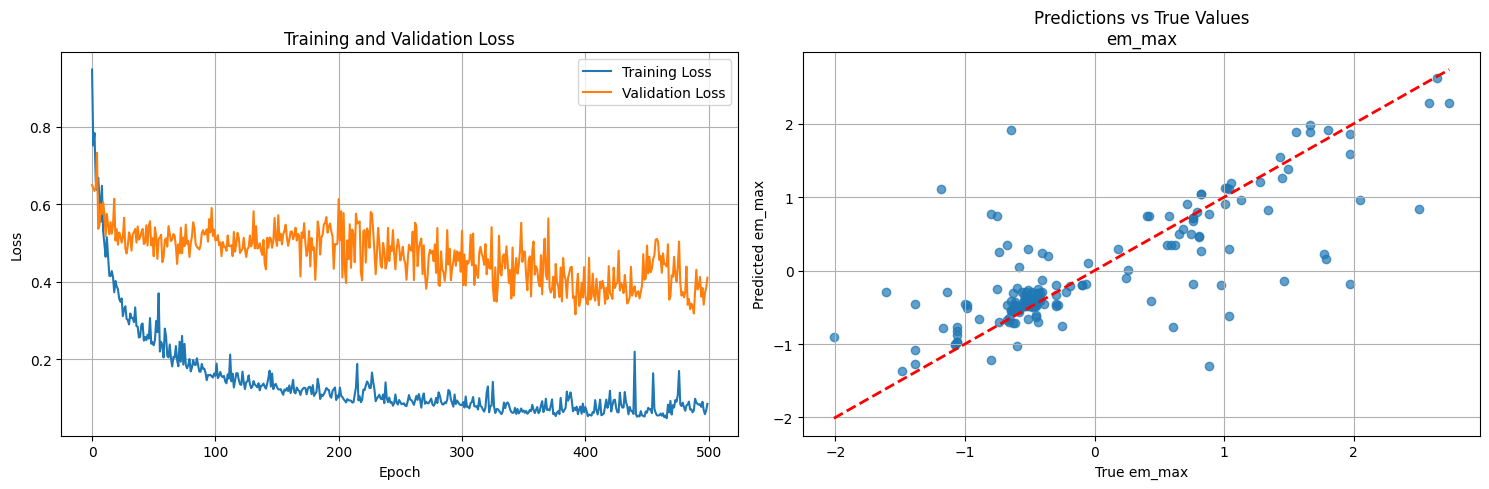


Model saved as 'lstm_model_em_max_onehot.pth'


In [34]:
"""Main training pipeline."""
TARGET_PROPERTY = 'em_max'  # Change this to predict different properties

# Available properties from your dataset:
# brightness, ex_max, em_max, ext_coeff, lifetime, maturation, pka, stokes_shift, qy, agg, switch_type

# Hyperparameters
MAX_LENGTH = 256
BATCH_SIZE = 64
NUM_EPOCHS = 500
LEARNING_RATE = 0.001

# sample_batch = next(iter(train_loader))[0]
# embedding_dim = sample_batch.shape[-1]


# Instantiate the new model
# выбор между EmbeddingLSTM и ProteinLSTM
model = ProteinLSTM(
    hidden_dim=128,
    num_layers=1,
    output_dim=1,
    dropout=0.3,
    bidirectional=True
)

# Train the model
print(train_loader.dataset.tensors)
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model 
torch.save(trained_model.state_dict(), f'lstm_model_{TARGET_PROPERTY}_onehot.pth')
print(f"\nModel saved as 'lstm_model_{TARGET_PROPERTY}_onehot.pth'")


<h3>Работа с EmbeddingLSTM</h3>

In [24]:
for i in train_loader:
    print(i)
    print(i[0].shape)
    break

[tensor([[[ 0.0095, -0.0037,  0.0018,  ...,  0.0035, -0.0043, -0.0087],
         [-0.0076,  0.0092,  0.0323,  ...,  0.0323,  0.0138,  0.0291],
         [-0.0265, -0.0081,  0.0192,  ...,  0.0494, -0.0138,  0.0302],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0086, -0.0076,  0.0013,  ...,  0.0053, -0.0034, -0.0081],
         [-0.0002, -0.0009,  0.0273,  ...,  0.0316,  0.0068,  0.0232],
         [-0.0430, -0.0011,  0.0155,  ...,  0.0350, -0.0010,  0.0321],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0110, -0.0042,  0.0029,  ...,  0.0046, -0.0053, -0.0088],
         [-0.0016,  0.0108,  0.0379,  ...,  

In [32]:
"""Main training pipeline."""
TARGET_PROPERTY = 'em_max'  # Change this to predict different properties

# Available properties from your dataset:
# brightness, ex_max, em_max, ext_coeff, lifetime, maturation, pka, stokes_shift, qy, agg, switch_type

# Hyperparameters
MAX_LENGTH = 238
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

sample_batch = next(iter(train_loader))[0]
embedding_dim = sample_batch.shape[-1]

# Instantiate the new model
# выбор между EmbeddingLSTM и ProteinLSTM
model = EmbeddingLSTM(
    embed_dim=embedding_dim,
    hidden_size=128,
    num_layers=2,
    dropout_rate=0.1
).to(device)

# Train the model
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model
torch.save(trained_model.state_dict(), f'weights/lstm_model_{TARGET_PROPERTY}_embeddings.pth')
print(f"\nModel saved as 'lstm_model_{TARGET_PROPERTY}_embeddings.pth'")


NameError: name 'EmbeddingLSTM' is not defined

### Работа с CNN + ESM C

Training on cuda
Number of parameters: 833,329


Epoch 1/100:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/100: 100%|██████████| 17/17 [00:01<00:00, 14.98it/s]


Epoch 5/100
Train Loss: 0.8638, Val Loss: 0.7820
Learning Rate: 0.000100
--------------------------------------------------


Epoch 10/100: 100%|██████████| 17/17 [00:00<00:00, 22.64it/s]


Epoch 10/100
Train Loss: 0.4974, Val Loss: 0.3716
Learning Rate: 0.000100
--------------------------------------------------


Epoch 15/100: 100%|██████████| 17/17 [00:00<00:00, 24.04it/s]


Epoch 15/100
Train Loss: 0.3625, Val Loss: 0.3286
Learning Rate: 0.000100
--------------------------------------------------


Epoch 20/100: 100%|██████████| 17/17 [00:00<00:00, 21.49it/s]


Epoch 20/100
Train Loss: 0.3299, Val Loss: 0.3348
Learning Rate: 0.000100
--------------------------------------------------


Epoch 25/100: 100%|██████████| 17/17 [00:00<00:00, 18.39it/s]


Epoch 25/100
Train Loss: 0.2940, Val Loss: 0.2832
Learning Rate: 0.000100
--------------------------------------------------


Epoch 30/100: 100%|██████████| 17/17 [00:00<00:00, 20.40it/s]


Epoch 30/100
Train Loss: 0.2687, Val Loss: 0.3196
Learning Rate: 0.000100
--------------------------------------------------


Epoch 35/100: 100%|██████████| 17/17 [00:00<00:00, 20.39it/s]


Epoch 35/100
Train Loss: 0.2394, Val Loss: 0.2775
Learning Rate: 0.000100
--------------------------------------------------


Epoch 40/100: 100%|██████████| 17/17 [00:00<00:00, 20.47it/s]


Epoch 40/100
Train Loss: 0.3112, Val Loss: 0.2848
Learning Rate: 0.000100
--------------------------------------------------


Epoch 45/100: 100%|██████████| 17/17 [00:00<00:00, 20.91it/s]


Epoch 45/100
Train Loss: 0.2611, Val Loss: 0.3201
Learning Rate: 0.000100
--------------------------------------------------


Epoch 50/100: 100%|██████████| 17/17 [00:00<00:00, 20.68it/s]


Epoch 50/100
Train Loss: 0.1972, Val Loss: 0.2530
Learning Rate: 0.000100
--------------------------------------------------


Epoch 55/100: 100%|██████████| 17/17 [00:00<00:00, 23.03it/s]


Epoch 55/100
Train Loss: 0.1823, Val Loss: 0.2452
Learning Rate: 0.000100
--------------------------------------------------


Epoch 60/100: 100%|██████████| 17/17 [00:00<00:00, 26.05it/s]


Epoch 60/100
Train Loss: 0.1973, Val Loss: 0.2777
Learning Rate: 0.000100
--------------------------------------------------


Epoch 65/100: 100%|██████████| 17/17 [00:00<00:00, 24.57it/s]


Epoch 65/100
Train Loss: 0.1826, Val Loss: 0.2494
Learning Rate: 0.000100
--------------------------------------------------


Epoch 70/100: 100%|██████████| 17/17 [00:00<00:00, 23.29it/s]


Epoch 70/100
Train Loss: 0.1712, Val Loss: 0.2581
Learning Rate: 0.000100
--------------------------------------------------


Epoch 75/100: 100%|██████████| 17/17 [00:00<00:00, 26.04it/s]


Epoch 75/100
Train Loss: 0.1834, Val Loss: 0.4305
Learning Rate: 0.000100
--------------------------------------------------


Epoch 80/100: 100%|██████████| 17/17 [00:00<00:00, 27.95it/s]


Epoch 80/100
Train Loss: 0.1631, Val Loss: 0.2408
Learning Rate: 0.000100
--------------------------------------------------


Epoch 85/100: 100%|██████████| 17/17 [00:00<00:00, 20.00it/s]


Epoch 85/100
Train Loss: 0.1593, Val Loss: 0.3935
Learning Rate: 0.000100
--------------------------------------------------


Epoch 90/100: 100%|██████████| 17/17 [00:00<00:00, 19.83it/s]


Epoch 90/100
Train Loss: 0.1556, Val Loss: 0.2902
Learning Rate: 0.000100
--------------------------------------------------


Epoch 95/100: 100%|██████████| 17/17 [00:00<00:00, 24.88it/s]


Epoch 95/100
Train Loss: 0.1410, Val Loss: 0.2255
Learning Rate: 0.000100
--------------------------------------------------


Epoch 100/100: 100%|██████████| 17/17 [00:00<00:00, 25.52it/s]


Epoch 100/100
Train Loss: 0.1276, Val Loss: 0.4241
Learning Rate: 0.000100
--------------------------------------------------

Test MSE: 0.2437
Test MAE: 0.3518
Test R²:  0.7278


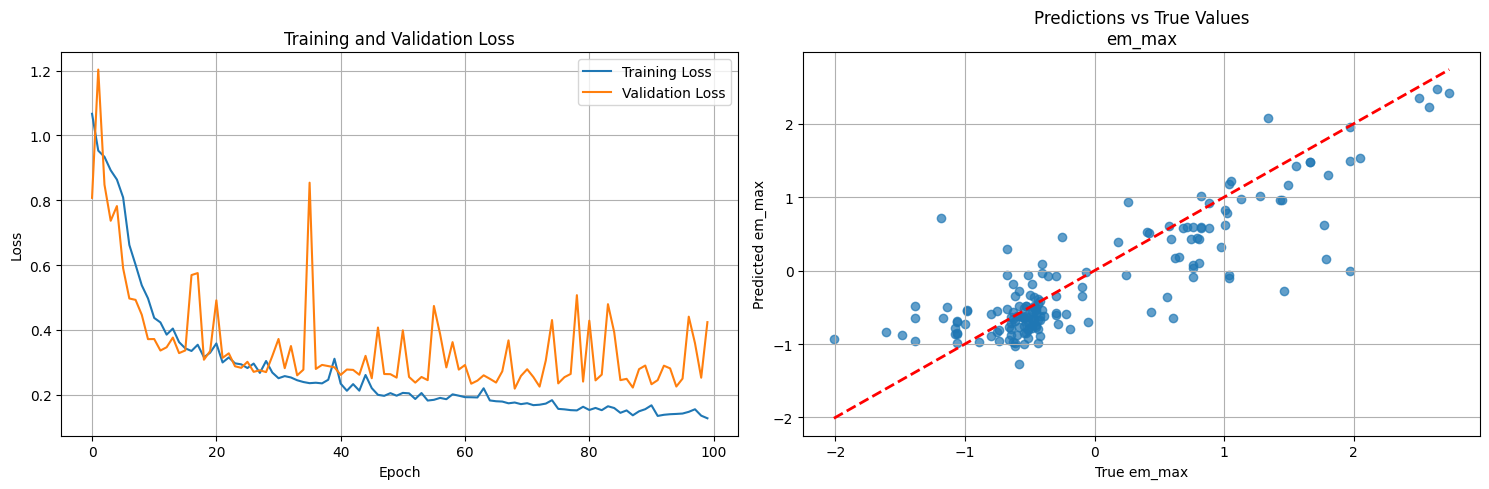

In [30]:
TARGET_PROPERTY = 'em_max'

BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001

model = EmbeddingsCNN().to(device)

trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

predictions, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

plot_results(train_losses, val_losses, predictions, true_values, TARGET_PROPERTY)

torch.save(trained_model.state_dict(), f'weights/cnn_model_{TARGET_PROPERTY}_custom.pth')
# print(f"Модель сохранена как 'cnn_model_{TARGET_PROPERTY}_custom.pth'")


### Работа с CNN

Training on cuda
Number of parameters: 1,562,113


Epoch 1/100:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/100: 100%|██████████| 17/17 [00:00<00:00, 26.96it/s]


Epoch 5/100
Train Loss: 0.5090, Val Loss: 0.3170
Learning Rate: 0.001000
--------------------------------------------------


Epoch 10/100: 100%|██████████| 17/17 [00:00<00:00, 26.61it/s]


Epoch 10/100
Train Loss: 0.3244, Val Loss: 0.9946
Learning Rate: 0.001000
--------------------------------------------------


Epoch 15/100: 100%|██████████| 17/17 [00:00<00:00, 26.90it/s]


Epoch 15/100
Train Loss: 0.3416, Val Loss: 0.3075
Learning Rate: 0.001000
--------------------------------------------------


Epoch 20/100: 100%|██████████| 17/17 [00:00<00:00, 27.04it/s]


Epoch 20/100
Train Loss: 0.3298, Val Loss: 0.3306
Learning Rate: 0.001000
--------------------------------------------------


Epoch 25/100: 100%|██████████| 17/17 [00:00<00:00, 26.93it/s]


Epoch 25/100
Train Loss: 0.3644, Val Loss: 0.4798
Learning Rate: 0.001000
--------------------------------------------------


Epoch 30/100: 100%|██████████| 17/17 [00:00<00:00, 26.69it/s]


Epoch 30/100
Train Loss: 0.3753, Val Loss: 0.2495
Learning Rate: 0.001000
--------------------------------------------------


Epoch 35/100: 100%|██████████| 17/17 [00:00<00:00, 27.05it/s]


Epoch 35/100
Train Loss: 0.1897, Val Loss: 0.2869
Learning Rate: 0.001000
--------------------------------------------------


Epoch 40/100: 100%|██████████| 17/17 [00:00<00:00, 27.00it/s]


Epoch 40/100
Train Loss: 0.2444, Val Loss: 16.8659
Learning Rate: 0.001000
--------------------------------------------------


Epoch 45/100: 100%|██████████| 17/17 [00:00<00:00, 26.76it/s]


Epoch 45/100
Train Loss: 0.1941, Val Loss: 0.4147
Learning Rate: 0.001000
--------------------------------------------------


Epoch 50/100: 100%|██████████| 17/17 [00:00<00:00, 26.98it/s]


Epoch 50/100
Train Loss: 0.1583, Val Loss: 0.2263
Learning Rate: 0.001000
--------------------------------------------------


Epoch 55/100: 100%|██████████| 17/17 [00:00<00:00, 26.99it/s]


Epoch 55/100
Train Loss: 0.2153, Val Loss: 0.7568
Learning Rate: 0.001000
--------------------------------------------------


Epoch 60/100: 100%|██████████| 17/17 [00:00<00:00, 26.94it/s]


Epoch 60/100
Train Loss: 0.1751, Val Loss: 0.3537
Learning Rate: 0.001000
--------------------------------------------------


Epoch 65/100: 100%|██████████| 17/17 [00:00<00:00, 26.34it/s]


Epoch 65/100
Train Loss: 0.1118, Val Loss: 0.3510
Learning Rate: 0.001000
--------------------------------------------------


Epoch 70/100: 100%|██████████| 17/17 [00:00<00:00, 26.80it/s]


Epoch 70/100
Train Loss: 0.2212, Val Loss: 10.3134
Learning Rate: 0.001000
--------------------------------------------------


Epoch 75/100: 100%|██████████| 17/17 [00:00<00:00, 22.72it/s]


Epoch 75/100
Train Loss: 0.1852, Val Loss: 0.3106
Learning Rate: 0.001000
--------------------------------------------------


Epoch 80/100: 100%|██████████| 17/17 [00:00<00:00, 23.48it/s]


Epoch 80/100
Train Loss: 0.1362, Val Loss: 0.1712
Learning Rate: 0.001000
--------------------------------------------------


Epoch 85/100: 100%|██████████| 17/17 [00:00<00:00, 26.21it/s]


Epoch 85/100
Train Loss: 0.1307, Val Loss: 3.7024
Learning Rate: 0.001000
--------------------------------------------------


Epoch 90/100: 100%|██████████| 17/17 [00:00<00:00, 26.67it/s]


Epoch 90/100
Train Loss: 0.1201, Val Loss: 0.3478
Learning Rate: 0.001000
--------------------------------------------------


Epoch 95/100: 100%|██████████| 17/17 [00:00<00:00, 26.72it/s]


Epoch 95/100
Train Loss: 0.0886, Val Loss: 0.6198
Learning Rate: 0.001000
--------------------------------------------------


Epoch 100/100: 100%|██████████| 17/17 [00:00<00:00, 26.58it/s]


Epoch 100/100
Train Loss: 0.1197, Val Loss: 20.0057
Learning Rate: 0.001000
--------------------------------------------------

Test MSE: 18.6482
Test MAE: 4.1822
Test R²:  -19.8328


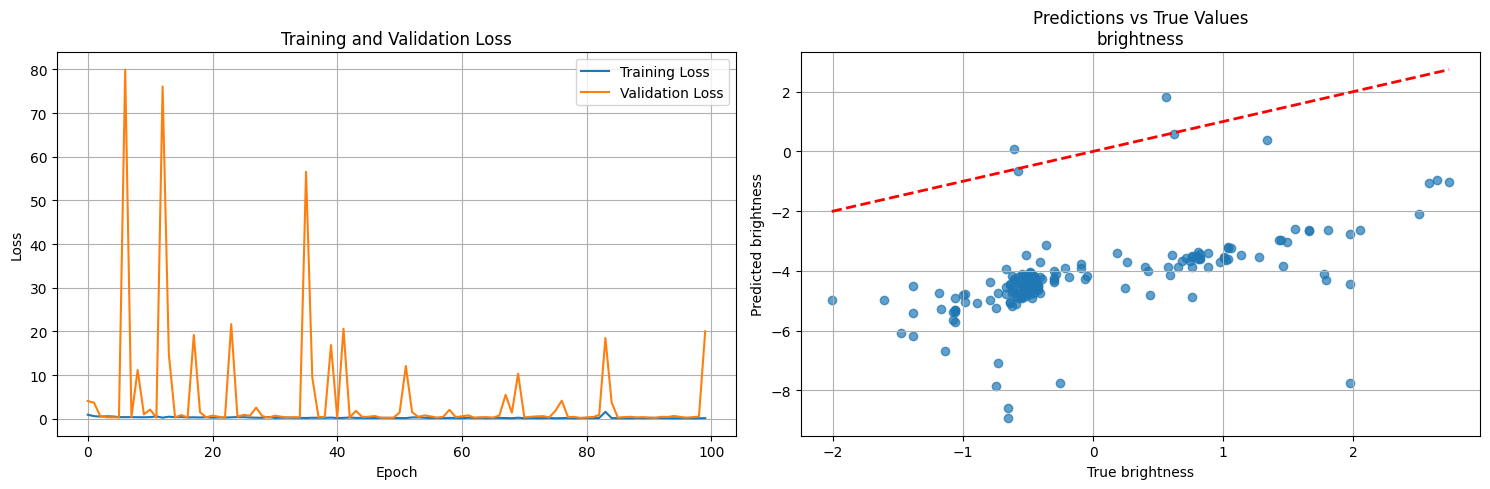


Model saved as 'cnn_model_brightness_onehot.pth'


In [ ]:
"""Main training pipeline."""
TARGET_PROPERTY = 'brightness'  

MAX_LENGTH = 256
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

model = ProteinCNN(
    num_amino_acids=20, 
    num_filters=128,
    dropout_rate=0.6
)

# Train the model
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model
torch.save(trained_model.state_dict(), f'weights/cnn_model_{TARGET_PROPERTY}_onehot.pth')
print(f"\nModel saved as 'cnn_model_{TARGET_PROPERTY}_onehot.pth'")

In [35]:
trained_model.eval()

predictions = []
true_values = []

with torch.no_grad():
    for sequences, targets in test_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        batch_predictions = model(sequences).squeeze()

        predictions.extend(batch_predictions.cpu().numpy())
        true_values.extend(targets.cpu().numpy())

    # Convert back to original scale
predictions = np.array(predictions)
true_values = np.array(true_values)
s_predictions = dataset.rescale_targets(predictions, TARGET_PROPERTY)
s_true_values = dataset.rescale_targets(true_values, TARGET_PROPERTY)

zv = get_regression_metrics(
    s_predictions,
    s_true_values
)
print(f'\t RMSE: {zv["rmse"]}')
print(f'\t MAE: {zv["mae"]}')
print(f'\t R2: {zv["r2"]}')
print(f'\t MAE (med.): {zv["mae_median"]}')


	 RMSE: 38.59299087524414
	 MAE: 22.503036499023438
	 R2: 0.5969847440719604
	 MAE (med.): 9.84552001953125


In [36]:
metrics_ci = bootstrap_metric_ci(
    s_predictions, s_true_values, get_regression_metrics, 
    n_bootstrap=1000, alpha=0.05, random_state=42
)

# Print results in a nice format
print("\nMetrics with 95% confidence intervals:")
print(f"RMSE: {(metrics_ci['rmse'][1] + metrics_ci['rmse'][2]) / 2:.2f} ± {(metrics_ci['rmse'][1] + metrics_ci['rmse'][2]) / 2 -metrics_ci['rmse'][1]:.2f}")
print(f"MAE: {(metrics_ci['mae'][1] + metrics_ci['mae'][2]) / 2:.2f} ± {(metrics_ci['mae'][1] + metrics_ci['mae'][2]) / 2 -metrics_ci['mae'][1]:.2f}")
print(f"R2: {(metrics_ci['r2'][1] + metrics_ci['r2'][2]) / 2:.2f} ± {(metrics_ci['r2'][1] + metrics_ci['r2'][2]) / 2 -metrics_ci['r2'][1]:.2f}")
print(f"MAE Median: {(metrics_ci['mae_median'][1] + metrics_ci['mae_median'][2]) / 2:.2f} ± {(metrics_ci['mae_median'][1] + metrics_ci['mae_median'][2]) / 2 -metrics_ci['mae_median'][1]:.2f}")


Metrics with 95% confidence intervals:
RMSE: 38.30 ± 7.32
MAE: 22.64 ± 4.54
R2: 0.58 ± 0.16
MAE Median: 10.07 ± 2.40
